### Imports

In [1]:
from collections import deque
import random
from random import sample

import numpy as np
import gym
import optuna
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use(['science','ieee'])

import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cpu")

### Define Agent

In [2]:
class DQNNet(nn.Module):
    """
    Defines a single DQN Network for the OpenAI Lunar Lander
    environment
    """
    def __init__(self, hidden_layers, layer_size):
        assert hidden_layers==2 or hidden_layers==3
        self.hidden_layers = hidden_layers
        
        super(DQNNet, self).__init__()
        self.layer1 = nn.Linear(8, layer_size)
        self.layer2 = nn.Linear(layer_size, layer_size)
        if self.hidden_layers==3:
            self.layer3 = nn.Linear(layer_size, layer_size)
        self.layer4 = nn.Linear(layer_size, 4)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        if self.hidden_layers==3:
            x = F.relu(self.layer3(x))
        return self.layer4(x)

class DQNAgent():
    def __init__(self, hidden_layers, layer_size, gamma,
              replay_size, target_update, start_e, beta,
              e_min, alpha, batch_size, seed=1):
        
        # Initialize networks with same parameters
        self.train_net = DQNNet(hidden_layers, layer_size)
        self.target_net = DQNNet(hidden_layers, layer_size)
        self.target_net.eval()
        self.target_net.load_state_dict(self.train_net.state_dict())
        
        # Initialize attributes and hyper-parameters
        self.env = gym.make('LunarLander-v2')
        self.gamma = gamma
        self.beta = beta
        self.replay_size = replay_size
        self.replay = deque(maxlen = replay_size)
        self.target_update = target_update
        self.batch_size = batch_size
        
        self.epsilon = start_e
        self.beta = beta
        self.e_min = e_min
        
        self.loss = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.train_net.parameters(), lr=alpha)
        
        # Set seeds
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        self.env.seed(seed)
    
    def sample_from_exp_replay(self):
        exp_replay = sample(self.replay, self.batch_size)
        S = torch.tensor(np.array([e[0] for e in exp_replay]), dtype=torch.float)
        A = torch.tensor([e[1] for e in exp_replay], dtype=torch.int64)
        R = torch.tensor([e[2] for e in exp_replay], dtype=torch.float)
        S_ = torch.tensor(np.array([e[3] for e in exp_replay]), dtype=torch.float)
        D = torch.tensor([e[4] for e in exp_replay], dtype=torch.float)
        return S, A, R, S_, D
        
    def fill_memory(self):
        s = self.env.reset()
        for _ in range(self.replay_size):
            a = np.random.randint(4)
            s_, r, done, _ = self.env.step(a)
            self.replay.append([s,a,r,s_,done])
            s = s_
            if done:
                s = self.env.reset()
        
    def train(self, episodes, verbose=False):
        self.fill_memory()
        i = 0
        ep_rewards = np.zeros(episodes)
        for ep in tqdm(range(episodes)):
            ep_reward = 0
            done = False
            s = self.env.reset()
            ep_len = 0
            while not done and ep_len<1_000:
                
                ep_len += 1
                i = (i+1)%self.target_update
                
                # Pick action epsilon-greedy
                if np.random.random() < self.epsilon:
                    a = np.random.randint(4)
                else:
                    with torch.no_grad():
                        x = self.train_net(torch.tensor(s, dtype=torch.float))
                    a = x.numpy().argmax()
                
                # Remember outcome
                s_, r, done, _ = self.env.step(a)
                ep_reward += r
                self.replay.append([s,a,r,s_,done])
                s = s_
                
                # Sample batch from replay memory
                if len(self.replay) < self.batch_size:
                    continue
                S, A, R, S_, D = self.sample_from_exp_replay()
                Q = self.train_net(S).gather(1,A[:, None])
                with torch.no_grad():
                    Q_ = self.target_net(S_)
                y = R + (self.gamma * (Q_.max(1).values) * (1-D))

                # Perform gradient descent
                loss = self.loss(y[:,None], Q)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                if i==0:
                    # Update target model
                    self.target_net.load_state_dict(self.train_net.state_dict())
            
            ep_rewards[ep] = ep_reward
            if verbose and not ep%100:
                print('episode', ep)
                print('reward', total_r, '   epsilon', self.epsilon)
                print(self.train_net(torch.tensor(np.zeros(8), dtype=torch.float)))
            # Apply epsilon decay after every episode
            self.epsilon = max(self.epsilon*self.beta, self.e_min)
        self.env.close()
        return ep_rewards
            
    def test(self, trials, verbose=False, return_mean=True):
        scores = np.zeros(trials)
        ep_lens = np.zeros(trials)
        for i in tqdm(range(trials)):
            score = 0
            s = self.env.reset()
            done = False
            ep_len = 0
            while not done:
                ep_len += 1
                with torch.no_grad():
                    x = self.target_net(torch.tensor(s, dtype=torch.float))
                a = x.numpy().argmax()
                s_, r, done, _ = self.env.step(a)
                s = s_
                score += r
            scores[i] = score
            ep_lens[i] = ep_len
        if verbose:
            print(f"Average score from {trials} trials = {score.mean()}")
        self.env.close()
        if return_mean:
            return scores.mean(), ep_lens.mean()
        return scores, ep_len

Agent = DQNAgent(2,64,0.99, 10_000,1_000,1.0,0.995,0.01,0.0005,64)

### Determine Ideal Hyperparameters

In [31]:
def objective(trial):
    hidden_layers = trial.suggest_int('hidden_layers', 2, 3)
    layer_size = trial.suggest_categorical('layer_size', [32, 64, 128])
    gamma = trial.suggest_float('gamma', 0.98,0.9999)
    target_update = trial.suggest_int('target_update', 100, 2000)
    beta = trial.suggest_float('epsilon decay', 0.98, 0.9999)
    alpha = trial.suggest_float('alpha', 0.00001, 0.01)
    batchsize = trial.suggest_categorical('batch', [32, 64, 128])
    e_min = trial.suggest_float('e-min', 0.001, 0.1)
    A = DQNAgent(hidden_layers,
                 layer_size,
                 gamma, 
                 10_000,
                 target_update,
                 1.0,
                 beta,
                 e_min,
                 alpha,
                 batchsize,
                )
    A.train(500, verbose=False)
    return A.test(100, verbose=False)[0]
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
# [I 2022-06-14 10:46:36,061] Trial 9 finished with value: 183.73210771551442 and parameters: {'hidden_layers': 2, 'layer_size': 128, 'gamma': 0.992578325471625, 'target_update': 1720, 'epsilon decay': 0.9813118390811589, 'alpha': 0.001129992157426724, 'batch': 32, 'e-min': 0.028297850424824248}. Best is trial 9 with value: 183.73210771551442.

[I 2022-06-14 14:47:03,293] A new study created in memory with name: no-name-f1dd4e79-9469-4d1a-b2f3-f23c8837901c
[I 2022-06-14 14:49:47,803] Trial 0 finished with value: -123.53840277556198 and parameters: {'hidden_layers': 2, 'layer_size': 64, 'gamma': 0.9993268298153845, 'target_update': 1655, 'epsilon decay': 0.9943185359932549, 'alpha': 0.007132520119789597, 'batch': 32, 'e-min': 0.03710286938445973}. Best is trial 0 with value: -123.53840277556198.
[I 2022-06-14 14:52:31,751] Trial 1 finished with value: -128.63411721169 and parameters: {'hidden_layers': 3, 'layer_size': 64, 'gamma': 0.9897742786289139, 'target_update': 1268, 'epsilon decay': 0.9947437989176037, 'alpha': 0.0034269743772649265, 'batch': 128, 'e-min': 0.07201813836243137}. Best is trial 0 with value: -123.53840277556198.
[I 2022-06-14 14:53:33,286] Trial 2 finished with value: -214.76676845098922 and parameters: {'hidden_layers': 3, 'layer_size': 32, 'gamma': 0.9815739592030228, 'target_update': 1997, 'epsilon deca

KeyboardInterrupt: 

### Plot rewards through training episodes

In [3]:
Agent = DQNAgent(2,
             64,
             0.99, 
             10_000,
             1_000,
             1.0,
             0.995,
             0.01,
             0.0005,
             64,
            )
rewards_train = Agent.train(750)

100%|██████████| 750/750 [08:28<00:00,  1.47it/s]


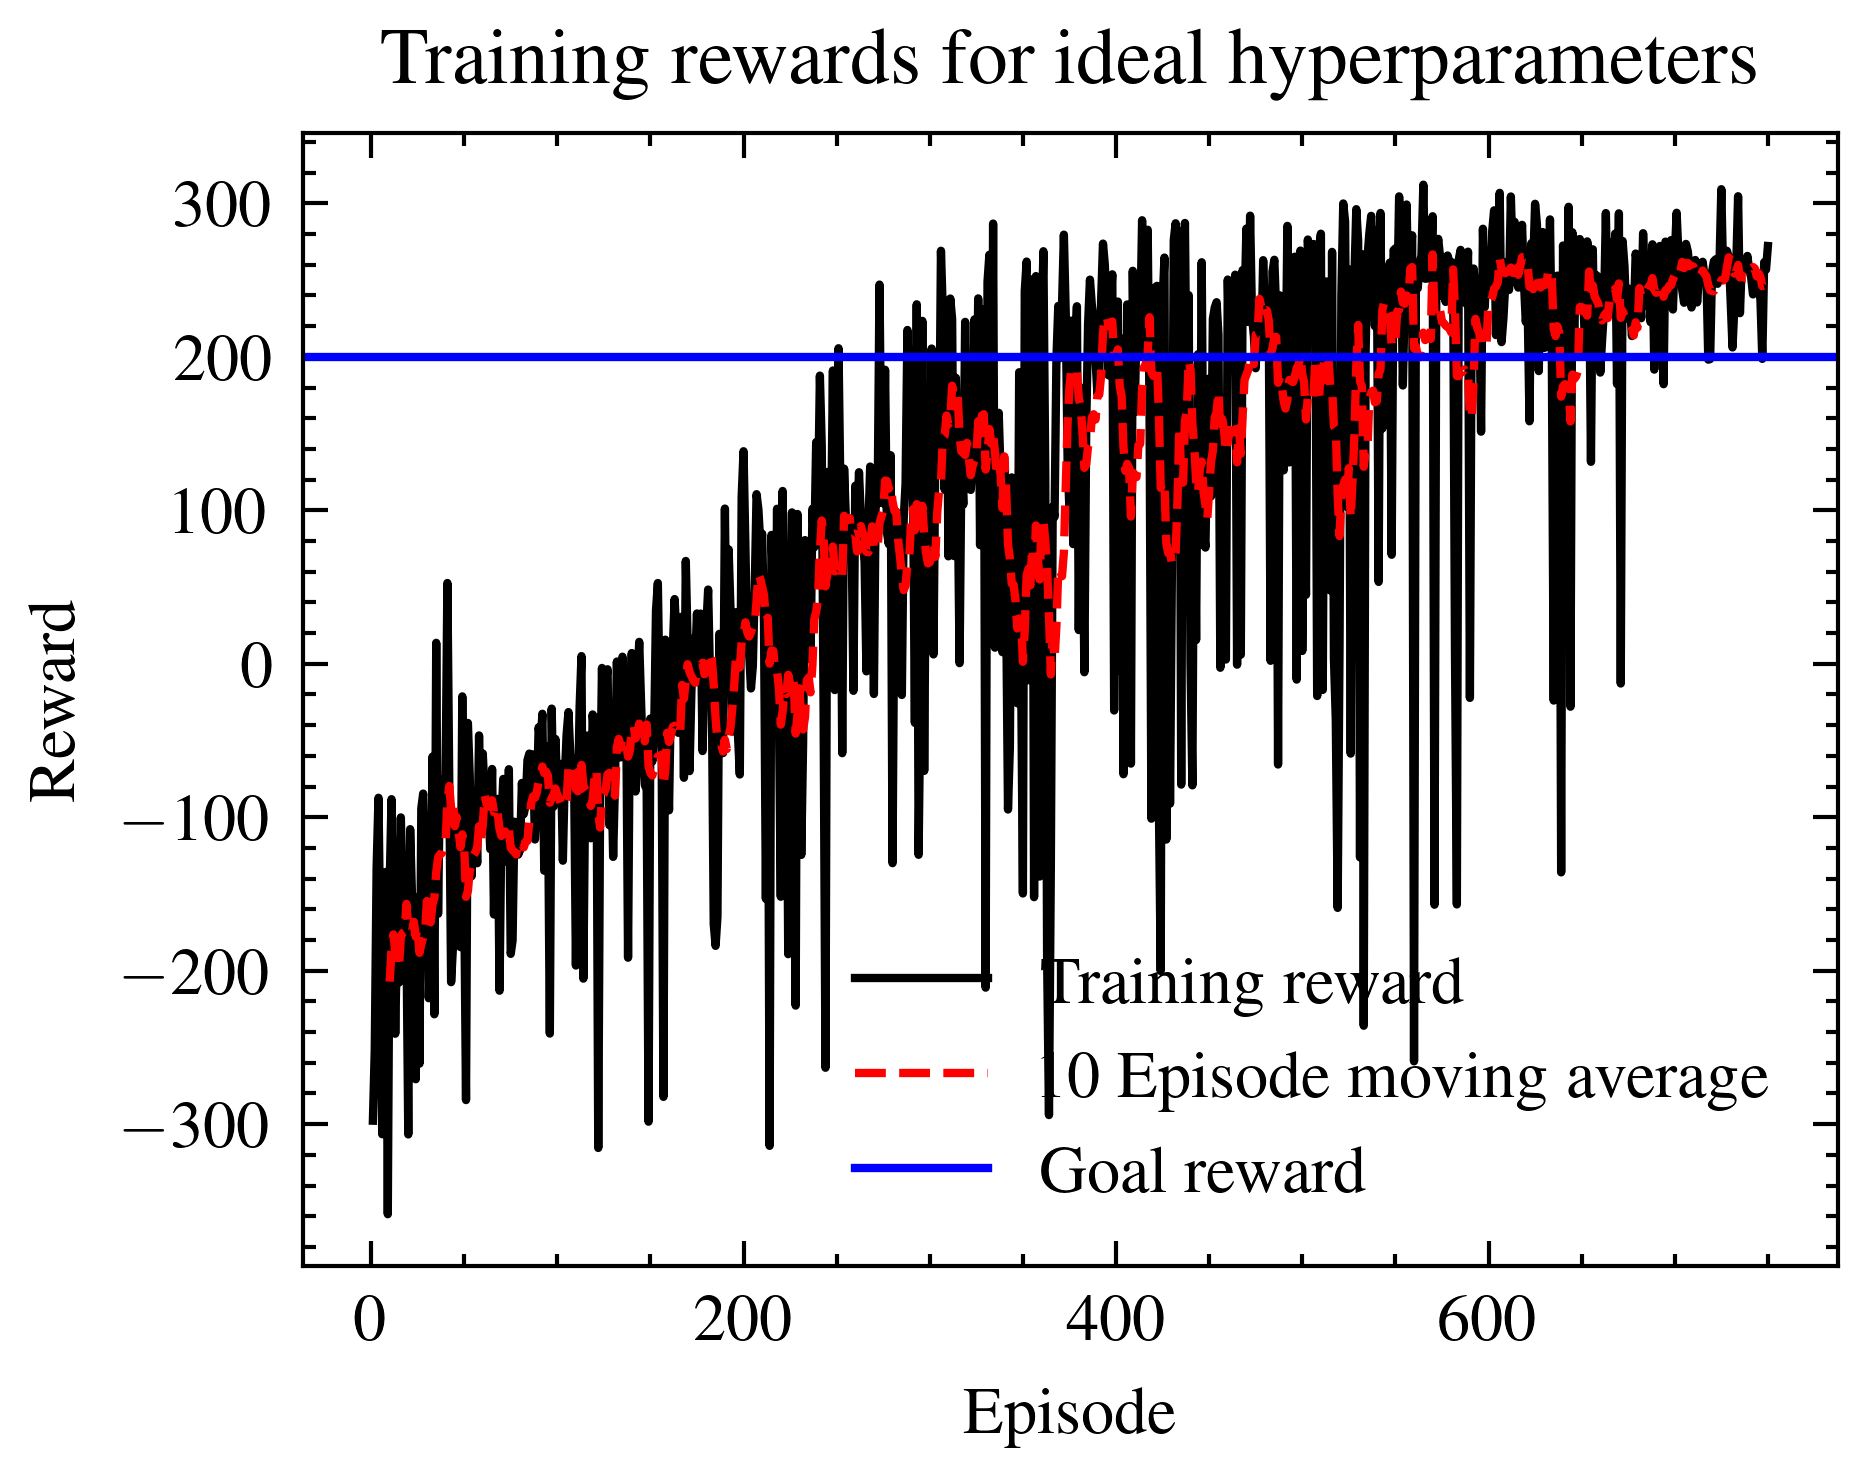

In [4]:
n = 10 # moving average length
moving_avg = np.convolve(rewards_train, np.ones(n)/n, mode='valid')
plt.plot(np.arange(len(rewards_train))+1, rewards_train, label='Training reward')
plt.plot(np.arange(len(rewards_train)-(n-1))+n, moving_avg, label=f'{n} Episode moving average')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training rewards for ideal hyperparameters')
plt.axhline(y=200, label='Goal reward', c='b')
plt.legend()
plt.savefig('RL_P2_Training.pdf')

### Plot training through testing episodes

In [21]:
rewards_test, _ = Agent.test(100, return_mean=False)

  0%|          | 0/100 [00:00<?, ?it/s]

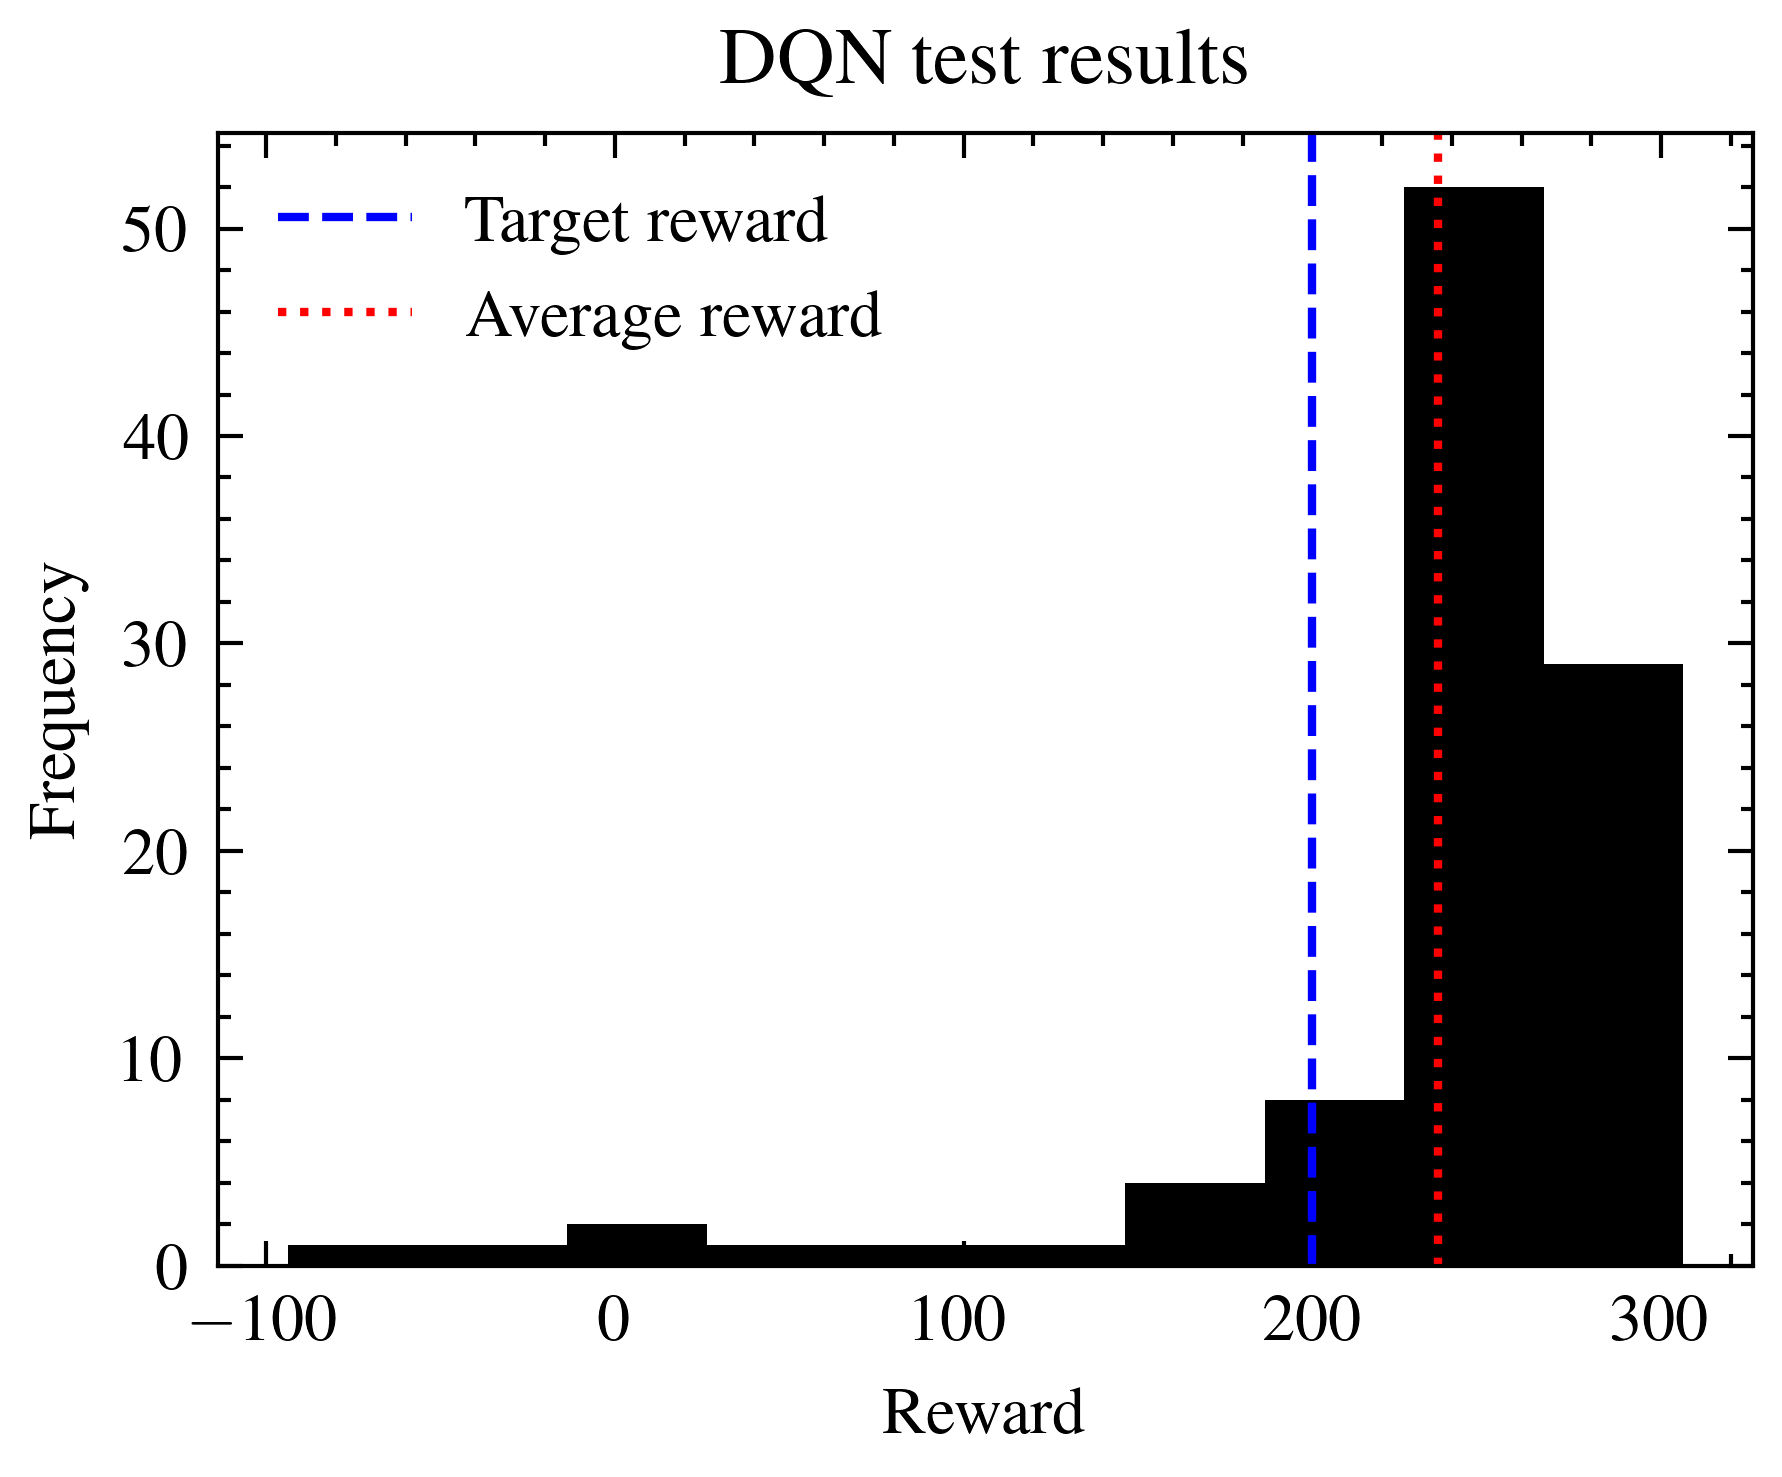

In [22]:
plt.hist(rewards_test)
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.title('DQN test results')
plt.axvline(x=200, c='b', ls='--', label='Target reward')
plt.axvline(x=rewards_test.mean(), c='r', ls=':', label='Average reward')
plt.legend()
plt.savefig('RL_P2_Testing.pdf')

### Record video for single episode

In [14]:
env = gym.wrappers.Monitor(gym.make('LunarLander-v2'), './video', force=True)
s = env.reset()
done = False
while not done:
    with torch.no_grad():
        x = Agent.target_net(torch.tensor(s, dtype=torch.float))
    a = x.numpy().argmax()
    s, r, done, _ = env.step(a)
env.close()

### Hyperparameter Tuning: $\gamma$

In [30]:
rewards_gamma = []
ep_lens = []
gammas = [0.9, 0.99, 0.999, 1]
for gamma in gammas:
    Agent = DQNAgent(2,
                 64,
                 gamma, 
                 10_000,
                 1_000,
                 1.0,
                 0.995,
                 0.01,
                 0.0005,
                 64,
                )
    Agent.train(750)
    r, l = Agent.test(100)
    rewards_gamma.append(r)
    ep_lens.append(l)

100%|██████████| 100/100 [00:05<00:00, 16.70it/s]


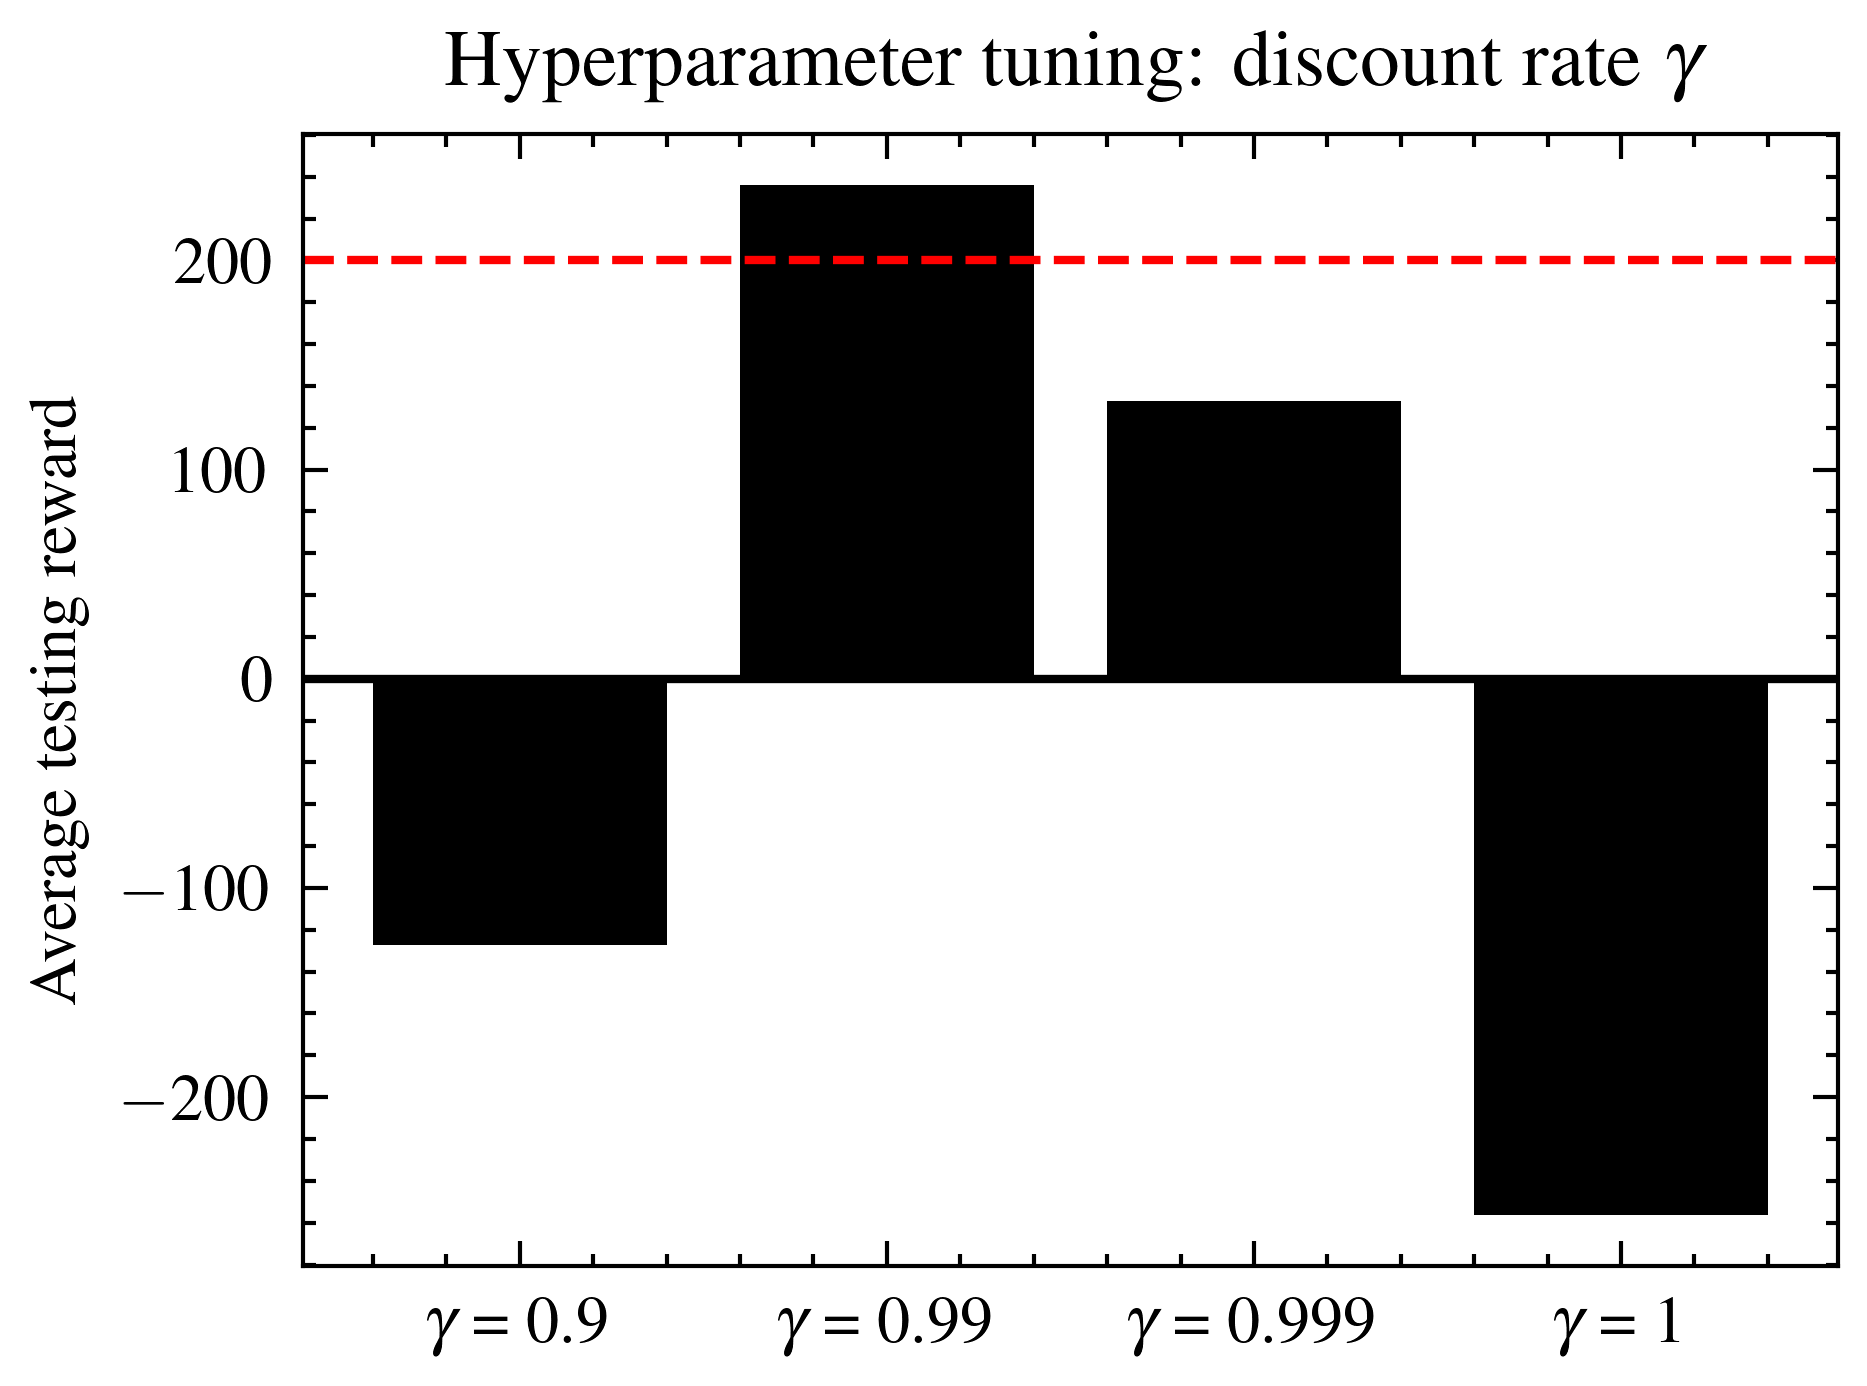

In [31]:
gamma_labels = [fr'$\gamma$ = {g}' for g in gammas]
plt.bar(gamma_labels, rewards_gamma)
plt.ylabel('Average testing reward')
plt.title(r'Hyperparameter tuning: discount rate $\gamma$')
plt.axhline(y=200, c='r', ls='--')
plt.axhline(y=0)
plt.savefig('RL_P2_HP_gamma.pdf')

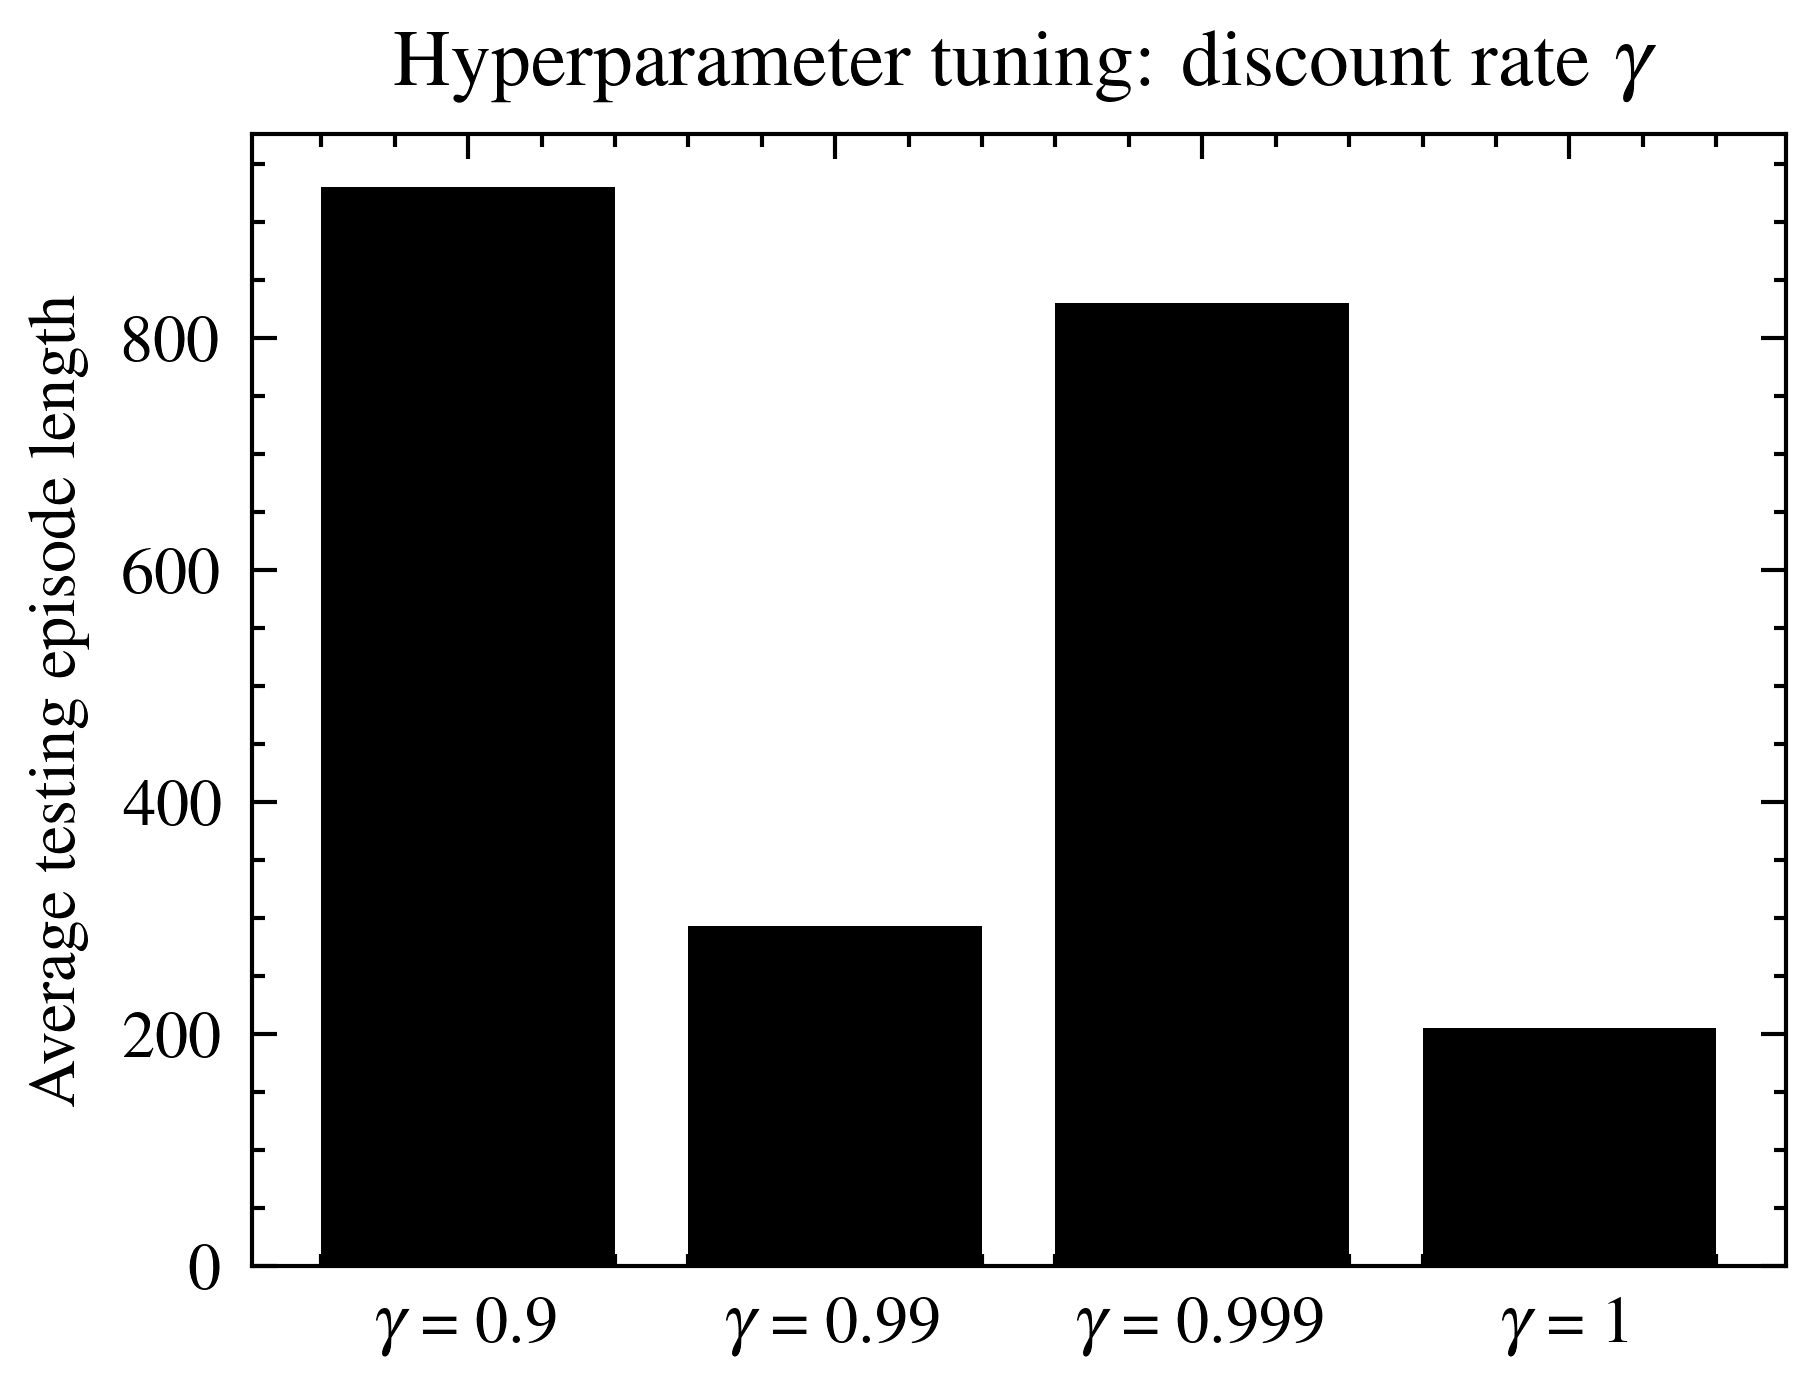

In [32]:
gamma_labels = [fr'$\gamma$ = {g}' for g in gammas]
plt.bar(gamma_labels, ep_lens)
plt.ylabel('Average testing episode length')
plt.title(r'Hyperparameter tuning: discount rate $\gamma$')
plt.savefig('RL_P2_HP_gamma2.pdf')

### Hyperparameter Tuning: $\beta$

In [33]:
rewards_beta = []
betas = [0.8, 0.95, 0.995, 0.9995]
for beta in betas:
    Agent = DQNAgent(2,
                 64,
                 0.99, 
                 10_000,
                 1_000,
                 1.0,
                 beta,
                 0.01,
                 0.0005,
                 64,
                )
    Agent.train(750)
    rewards_beta.append(Agent.test(100)[0])

100%|██████████| 100/100 [00:13<00:00,  7.47it/s]


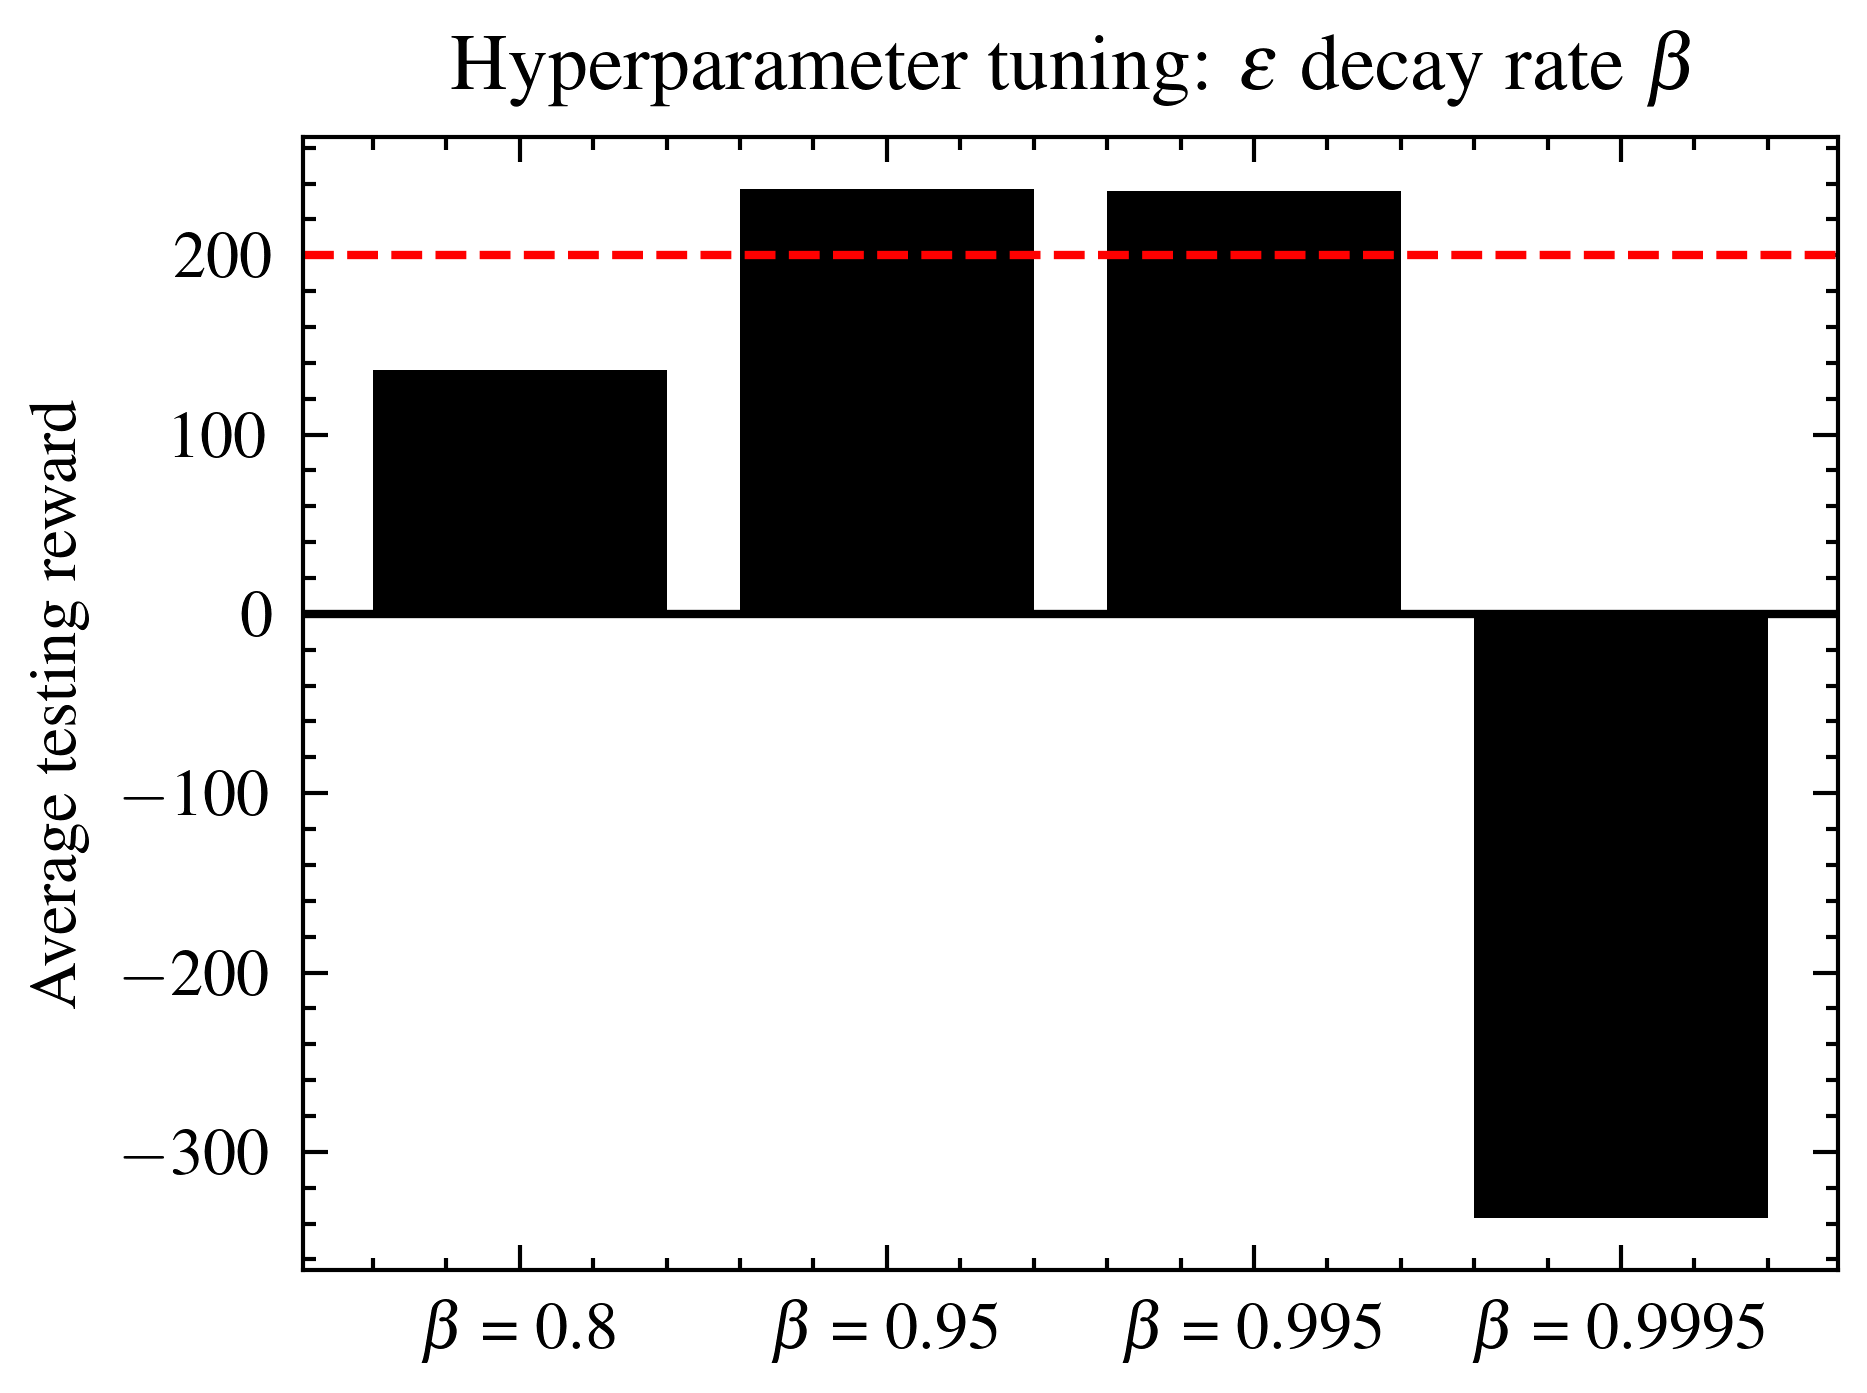

In [34]:
beta_labels = [fr'$\beta$ = {b}' for b in betas]
plt.bar(beta_labels, rewards_beta)
plt.ylabel('Average testing reward')
plt.title(r'Hyperparameter tuning: $\epsilon$ decay rate $\beta$')
plt.axhline(y=200, c='r', ls='--')
plt.axhline(y=0)
plt.savefig('RL_P2_HP_beta.pdf')

### Hyperparameter Tuning: $\alpha$

In [21]:
alphas = [5e-2, 5e-3, 5e-4, 5e-5]
rewards_alphas = []
for alpha in alphas:
    Agent = DQNAgent(2,
                 64,
                 0.99, 
                 10_000,
                 1_000,
                 1.0,
                 0.995,
                 0.01,
                 alpha,
                 64,
                )
    Agent.train(750)
    rewards_alphas.append(Agent.test(100)[0])

100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


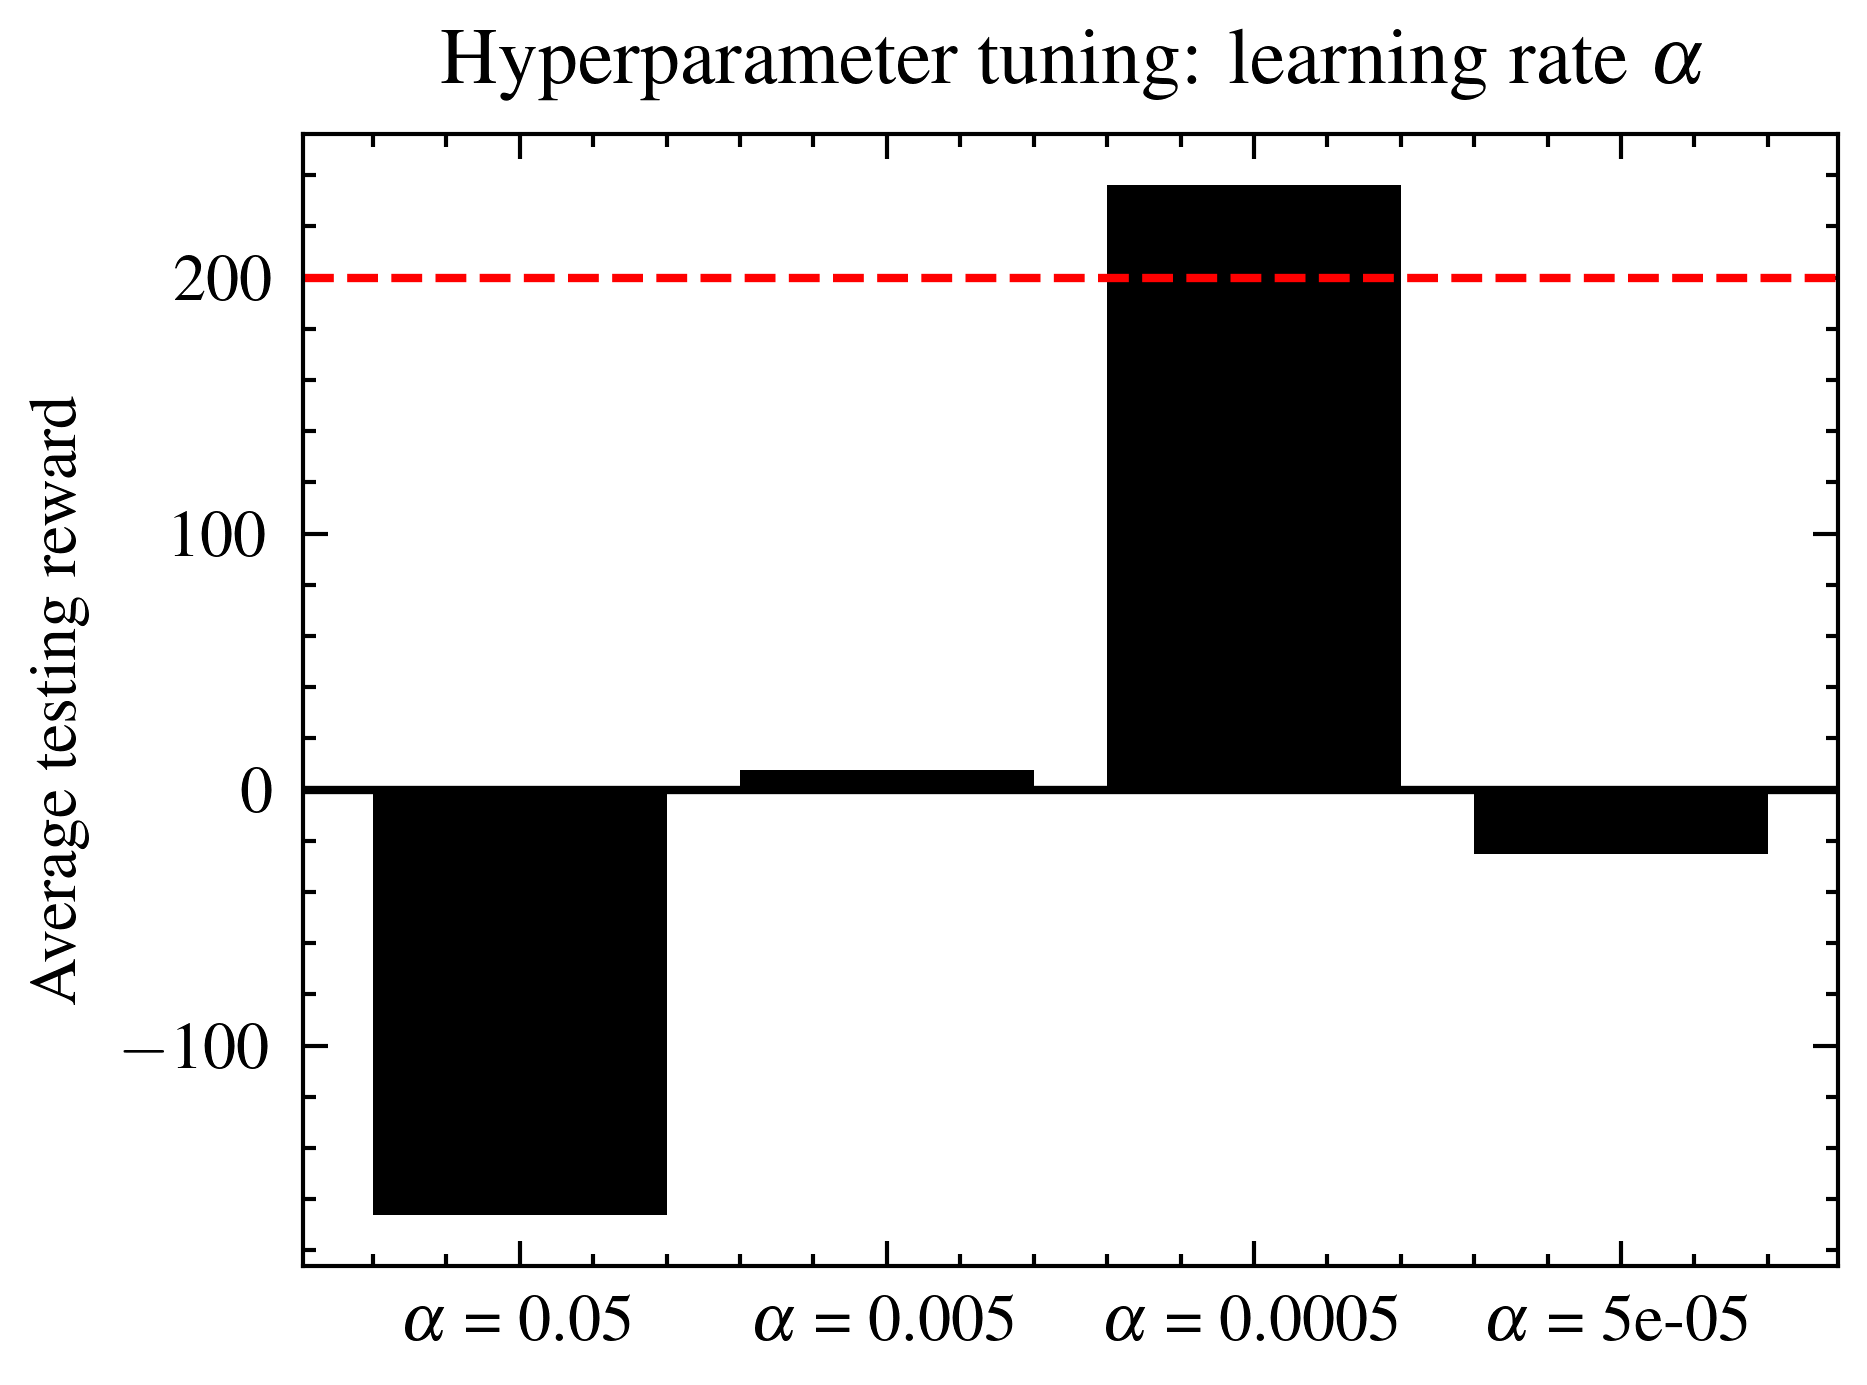

In [22]:
alpha_labels = [fr'$\alpha$ = {a}' for a in alphas]
plt.bar(alpha_labels, rewards_alphas)
plt.ylabel('Average testing reward')
plt.title(r'Hyperparameter tuning: learning rate $\alpha$')
plt.axhline(y=200, c='r', ls='--')
plt.axhline(y=0)
plt.savefig('RL_P2_HP_alpha.pdf')